In [8]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

sys.path.append('../')

from utils import load_atp_data

In [76]:
def kelly_winner_bet(row):
    
    base = row['model_w_pred']
    sub = (1 - base) / (row['psw'] - 1)
    
    return base - sub

def kelly_loser_bet(row):
    
    base = row['model_l_pred']
    sub = (1 - base) / (row['psl'] - 1)
    
    return base -sub

In [11]:
# loading all atp data
df = load_atp_data('../tennis_atp')

shape before dropping match dupes: (583792, 75)
shape after dropping match dupes: (583731, 75)


In [13]:
# loading the data with model predictions
oof_df = pd.read_csv("../data/prediction_df.csv", parse_dates=['player_tourney_date'])

In [5]:
# loading the betting data 
years = ['2021.xlsx', '2022.xlsx', '2023.xlsx']

folder = '../tennis_betting_data/'

betting_df = pd.DataFrame()

for year in years:
    df_ = pd.read_excel(f'{folder}{year}')
    betting_df = pd.concat([betting_df, df_])
    
betting_df['date_monday'] = betting_df['Date'] - pd.offsets.Week(weekday=0)
betting_df['winner_last_name'] = [x.split()[0] for x in betting_df.Winner]
betting_df['loser_last_name'] = [x.split()[0] for x in betting_df.Loser]

betting_df.drop(columns='Surface', inplace=True)

In [14]:
# creating a list->tuple of the players in each match
# we'll use these tuples to merge the dataframes 
# this shouldnt be necessary but i foolishly messed up the
# indices in the model df
unique_match_players = df[['winner_id', 'loser_id']].values.tolist()
df['details'] = unique_match_players
df['details'] = [tuple(sorted(x)) for x in df['details']]

unique_match_players_oof = oof_df[['player_id', 'player_2_id']].values.tolist()
oof_df['details'] = unique_match_players_oof
oof_df['details'] = [tuple(sorted(x)) for x in oof_df['details']]

# creating the assessment df by merging the two
assess_df = (
    oof_df
    .merge(df, how='left', left_on=['player_tourney_date', 'details'],
           right_on=['tourney_date', 'details'])
)

# indicating when player_id in oof_df matches winner
assess_df['player_one_winner'] = np.where(assess_df['player_id'] == assess_df['winner_id'], 1, 0)
assess_df['winner_last_name'] = [x.split()[-1] for x in assess_df.winner_name]
assess_df['loser_last_name'] = [x.split()[-1] for x in assess_df.loser_name]

In [82]:
# creating the trial dataframe to test our model

trial = assess_df.merge(betting_df, how='left', left_on=['tourney_date', 'winner_last_name', 'loser_last_name'],
                 right_on=['date_monday', 'winner_last_name', 'loser_last_name'])

trial = trial[~trial['date_monday'].isnull()]
trial.columns = trial.columns.str.lower()

# calculating odds with and without vigorish for the average price
trial['avg_vegas_pred_w'] = 1 / trial['avgw']
trial['avg_vegas_pred_l'] = 1 / trial['avgl']
trial['avg_overround'] = trial[['avg_vegas_pred_w', 'avg_vegas_pred_l']].sum(axis=1)
trial['avg_w_no_vig'] = trial['avg_vegas_pred_w'].div(trial['avg_overround'])
trial['avg_l_no_vig'] = trial['avg_vegas_pred_l'].div(trial['avg_overround'])

# calculating odds with and without vigorish for pinnacle
trial['pinnacle_vegas_pred_w'] = 1 / trial['psw']
trial['pinnacle_vegas_pred_l'] = 1 / trial['psl']
trial['pinnacle_overround'] = trial[['pinnacle_vegas_pred_w', 'pinnacle_vegas_pred_l']].sum(axis=1)
trial['pinnacle_w_no_vig'] = trial['pinnacle_vegas_pred_w'].div(trial['pinnacle_overround'])
trial['pinnacle_l_no_vig'] = trial['pinnacle_vegas_pred_l'].div(trial['pinnacle_overround'])

# converting the model predictions to winner and loser predictions
trial['model_w_pred'] = np.where(trial['player_one_winner'] == 1,
                                 trial['pred_player_one_win'],
                                 1 - trial['pred_player_one_win'])

trial['model_l_pred'] = 1 - trial['model_w_pred']

# calculating kelly bet given predictions
trial['winner_kelly_bet'] = trial.apply(kelly_winner_bet, axis=1)
trial['loser_kelly_bet'] = trial.apply(kelly_loser_bet, axis=1)

# dropping all rows where we don't have a vegas prediction
# and eliminating some anomalies
trial = trial[~trial['avg_vegas_pred_w'].isnull()].copy()
trial = trial[~trial['pinnacle_vegas_pred_w'].isnull()].copy()
trial = trial[trial['pinnacle_vegas_pred_w'].between(0, 1)].copy()
trial = trial[trial['avg_overround'].between(1, 1.07)].copy()
trial = trial[trial['pinnacle_overround'].between(1, 1.03)].copy()

print(trial.shape)

(3226, 194)


In [83]:
trial['rearrange'] = np.random.choice([0, 1], size=len(trial))
trial['p1'] = np.where(trial['rearrange'] == 1, trial['pinnacle_vegas_pred_w'], trial['pinnacle_vegas_pred_l'])
trial['p2'] = np.where(trial['rearrange'] == 1, trial['model_w_pred'], trial['model_l_pred'])
trial['p3'] = np.where(trial['rearrange'] == 1, trial['avg_vegas_pred_w'], trial['avg_vegas_pred_l'])

print("the logloss for pinnacle:", log_loss(trial['rearrange'], trial['p1']))
print("the logloss for my model:", log_loss(trial['rearrange'], trial['p2']))
print("the logloss for avg vegas:", log_loss(trial['rearrange'], trial['p3']))

the logloss for pinnacle: 0.5748254634577388
the logloss for my model: 0.5824280598425258
the logloss for avg vegas: 0.5776862859841835


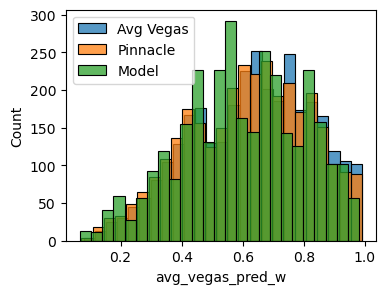

In [44]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(trial['avg_vegas_pred_w'], bins=25, label='Avg Vegas')
sns.histplot(trial['pinnacle_vegas_pred_w'], bins=25, label='Pinnacle')
sns.histplot(trial['model_w_pred'], bins=25, label='Model')

plt.legend()
plt.show()

In [34]:
model_brier = lambda x: brier_score_loss(x['player_one_winner'], x['model_w_pred'])
pinnacle_vegas_brier = lambda x: brier_score_loss(x['player_one_winner'], x['pinnacle_vegas_pred_w'])

briers_df = (
    pd.concat([trial.groupby(['season', 'tourney_name']).apply(model_brier),
               trial.groupby(['season', 'tourney_name']).apply(pinnacle_vegas_brier)], axis=1)
    .rename(columns={0 : 'model', 1 : 'pinnacle'})
)

briers_df['model_wins'] = (briers_df['model'] < briers_df['pinnacle']).astype(int)

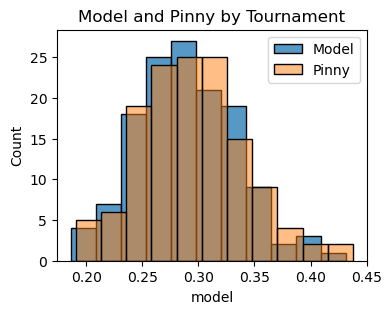

In [180]:
# plotting the performance of the model vs pinny
# across tourneys

fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(briers_df['model'], label='Model')
sns.histplot(briers_df['pinnacle'], label='Pinny', alpha=0.5)

plt.title("Model and Pinny by Tournament")
plt.legend()
plt.show()

# Does a Mixture of Vegas + Model Beat Vegas?  

The answer is yes, as can be seen below. That means  
we're likely on the right track, even if we aren't there yet.  
The model is capturing something useful.  

In [168]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

splitter = KFold(n_splits=100, shuffle=True)

oof = np.zeros(len(trial))

X = trial[['p1', 'p2']]
y = trial['rearrange']

for train, val in splitter.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y.iloc[train]
    
    val_x = X.iloc[val]
    
    model = LinearRegression()
    model.fit(train_x, train_y)
    
    preds = model.predict(val_x)
    oof[val] = preds

print("log loss for vegas only:", log_loss(y, trial['p1']))
print("log loss on the out of fold predictions", log_loss(y, oof))

log loss for vegas only: 0.5748254634577388
log loss on the out of fold predictions 0.5727791701860678


# Bootstrap Resampling  

Bootstrap resampling to estimate SE of log loss for the Pinnacle  
closing line and the model. Here we sample tourney_ids with  
replacement to account for the intra-tournament correlation in  
error from, for example, weather, court conditions, incentives  
invisible to me (home crowd, favorite tournament, critical career  
juncture, etc.)

In [170]:
# doing bootstrap resampling to estimate the mean and standard
# error of our log loss samples. it's likely that errors are correlated,
# so in each iteration we sample a set of tourney ids to compare.
# the standard error converges to 0.008 for vegas and 0.0083 for model

SAMPLES = 250
vegas_losses = []
model_losses = []

for _ in range(SAMPLES):

    tourneys = trial['tourney_id'].sample(55, replace=True)
    bootstrap_sample = trial[trial['tourney_id'].isin(tourneys)]
    
    vegas_loss = log_loss(bootstrap_sample['rearrange'], bootstrap_sample['p1'])
    model_loss = log_loss(bootstrap_sample['rearrange'], bootstrap_sample['p2'])
    
    vegas_losses.append(vegas_loss)
    model_losses.append(model_loss)

print("vegas mean and std of samples", np.mean(vegas_losses), np.std(vegas_losses, ddof=1))
print("model mean and std of samples", np.mean(model_losses), np.std(model_losses, ddof=1))

vegas mean and std of samples 0.5552140407823777 0.008084183534479933
model mean and std of samples 0.5620120885061041 0.008279715494092232


# Model Performance by Condition  

In [102]:
# calculating diff between market and model
trial['oof_mixture'] = oof
trial['abs_diff'] = abs(trial['p1'] - trial['p2'])
trial['diff_bin'] = pd.qcut(trial['abs_diff'], q=20)

trial['month'] = trial.tourney_date.dt.month
trial['season'] = trial.tourney_date.dt.year

In [182]:
month_comparison = (
    pd.concat(
        [trial.groupby('month').apply(lambda x: log_loss(x['rearrange'], x['p1'])), 
         trial.groupby('month').apply(lambda x: log_loss(x['rearrange'], x['p2']))], axis=1)
    .rename(columns={0 : 'vegas', 1 : 'model'})
)

month_comparison['matches'] = trial.groupby('month').size()
month_comparison['vegas_edge'] = month_comparison['model'] - month_comparison['vegas']

month_comparison

,vegas,model,matches,vegas_edge
month,,,,
1,0.584715,0.597111,323,0.012396
2,0.576748,0.595960,414,0.019212
3,0.594235,0.589152,320,-0.005083
4,0.600614,0.594272,266,-0.006342
5,0.536194,0.541713,349,0.005519
6,0.549976,0.560475,332,0.010499
7,0.603877,0.618313,254,0.014436
8,0.577350,0.589407,419,0.012057
9,0.579923,0.591635,176,0.011712
